<a href="https://colab.research.google.com/github/Untick/Marketplaces/blob/main/Shishkin%20Sergey/%D0%9F%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D1%81%D0%B0%D0%BC%D1%8B%D1%85_%D0%BA%D0%BE%D1%80%D1%80%D0%B5%D0%BB%D0%B8%D1%80%D1%83%D1%8E%D1%89%D0%B8%D1%85_%D0%BA%D0%BE%D0%BB%D0%BE%D0%BD%D0%BE%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание: Параметризация самых коррелирующих колонок, обобщение (избавиться от нулей), создание выборок для DL-модели регрессии

In [1]:
# Подключение библиотек
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd


In [2]:
# Для загрузки данных используем drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Дополнительный анализ данных показал, что файлы Аналитика Графики 01.06.2022-31.05.2023 и Аналитика Акции 01.06.2022-31.05.2023 являются эдентичными, т.е. данные по продажам, показам совпадают. В Акциях лиш указвается участвовал ли в этом периоде товар в какойто Акции. Поэтому суммировать данные из этих таблиц не корректно, просто удваиваем показатели. Эффект от участия в Акциях понадобится на следующих этапах исследований. На данном этапе при поиске рабочей модели предсказания эти данные усложнят работу с базой. В файле Графики есть все необходимые метрики: Просмотры, переходы, заказы, цена , позиция в поиске. Необходимо лишь дополнить базу Контент-рентингом из файла База.

In [3]:
# Загрузка файла в colab
sales = pd.read_excel('/content/gdrive/MyDrive/Аналитика Графики 01.06.2022-31.05.2023.xlsx', sheet_name= 'Sheet1')
content = pd.read_csv('/content/gdrive/MyDrive/База.csv', sep=";", header=0)
sales.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку"
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-03,1,1,6,1,4,"1,00",0,0,0,0,0,0,0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-05,1,0,2,0,2,"1,00",0,0,0,0,0,0,0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65,3,69,3,40,"110,33",0,0,0,0,0,0,0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85,3,109,3,46,"103,43",0,0,0,0,0,0,0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44,2,50,2,37,"97,14",0,0,0,0,0,0,0


In [4]:
content.head()

,Артикул,Ozon Product ID,FBO OZON SKU ID,FBS OZON SKU ID,Barcode,Наименование товара,Контент-рейтинг,Бренд,Статус товара,Видимость FBO,...,"Вывезти и нанести КИЗ (кроме Твери), шт","Зарезервировано, шт","Доступно на моих складах, шт","Зарезервировано на моих складах, шт","Текущая цена с учетом скидки, руб.","Цена до скидки (перечеркнутая цена), руб.","Цена Premium, руб.","Рыночная цена, руб.",Актуальная ссылка на рыночную цену,"Размер НДС, %"
0,'30273,105606938,298131117,298131122,2000000036618,Плата B003809.2 заднего фонаря BMW X3 F25 (дра...,'15,GNX,Продается,Показывается,...,0,0,26,0,1200.0,1800.0,NaN,NaN,NaN,0%
1,'30383,105742204,298264198,298264234,2000000037899,Биксеноновая линза GNX Hella 3R Crystal Vision...,'37.5,GNX,Продается,Показывается,...,0,0,410,0,1990.0,3500.0,NaN,NaN,NaN,0%
2,'31284,112525698,303785665,303785701,NaN,Светодиодные линзы Bi-Led AOZOOM A3 Max 5500K ...,'30,Aozoom,Продается,Показывается,...,0,0,10,0,7900.0,NaN,NaN,NaN,NaN,0%
3,'25775,175507357,409388811,409388809,2000000005034,Герметик для фар жесткий бутиловый черный (4 м...,'17.5,GNX,Продается,Показывается,...,0,0,873,0,1200.0,NaN,NaN,NaN,NaN,0%
4,'29740,175521273,409666236,409666237,2000000030531,Линзы ксенон для фар Ford Focus 2 2007-2011 (C...,'15,GNX,Продается,Показывается,...,0,0,47,0,4500.0,6300.0,NaN,NaN,NaN,0%


In [5]:
# Общая информация
sales.info()
content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254748 entries, 0 to 254747
Data columns (total 19 columns):
 #   Column                                                 Non-Null Count   Dtype 
---  ------                                                 --------------   ----- 
 0   Категория 3-го уровня                                  254748 non-null  object
 1   Товары                                                 254748 non-null  object
 2   Модель                                                 211411 non-null  object
 3   Ozon ID                                                254748 non-null  int64 
 4   Артикул                                                254748 non-null  object
 5   День                                                   254748 non-null  object
 6   Уникальные посетители, всего                           254748 non-null  int64 
 7   Уникальные посетители с просмотром карточки товара     254748 non-null  int64 
 8   Показы, всего                               

In [6]:
# удаляем не информативные колонки для выполнения поставленной задачи
sales.drop(
    ['Товары', 'Модель', 'Ozon ID', 'Отменено товаров',
     'Доставлено (за выбранный период)',
     'Возвращено товаров',
     'Отправления с премиум-подпиской, принятые в обработку'], axis=1, inplace=True)
sales.head()
sales.info()
content_1 = content[['Артикул', 'Контент-рейтинг']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254748 entries, 0 to 254747
Data columns (total 12 columns):
 #   Column                                              Non-Null Count   Dtype 
---  ------                                              --------------   ----- 
 0   Категория 3-го уровня                               254748 non-null  object
 1   Артикул                                             254748 non-null  object
 2   День                                                254748 non-null  object
 3   Уникальные посетители, всего                        254748 non-null  int64 
 4   Уникальные посетители с просмотром карточки товара  254748 non-null  int64 
 5   Показы, всего                                       254748 non-null  int64 
 6   Показы на карточке товара                           254748 non-null  int64 
 7   Показы в поиске и каталоге                          254748 non-null  int64 
 8   Позиция в поиске и каталоге                         254748 non-null  objec

In [7]:
content_1.head()

,Артикул,Контент-рейтинг
0,'30273,'15
1,'30383,'37.5
2,'31284,'30
3,'25775,'17.5
4,'29740,'15


In [8]:
# Перевод в датафрейме Графики данных столбца Позиция в поиске и каталоге в числовой формат
sales['Позиция в поиске и каталоге'] = sales['Позиция в поиске и каталоге'].str.replace(',','.').astype(float)
sales.head()

,Категория 3-го уровня,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Заказано на сумму
0,Разное автопринадлежности,34414,2023-03-03,1,1,6,1,4,1.00,0,0,0
1,Разное автопринадлежности,34414,2023-03-05,1,0,2,0,2,1.00,0,0,0
2,Разное автопринадлежности,34414,2023-03-05,65,3,69,3,40,110.33,0,0,0
3,Разное автопринадлежности,34414,2023-03-06,85,3,109,3,46,103.43,0,0,0
4,Разное автопринадлежности,34414,2023-03-07,44,2,50,2,37,97.14,0,0,0


In [9]:
# Очистка данных столбца Артикул и Контент-рейтинг и перевод в числовой формат
content_1['Артикул'] = content_1['Артикул'].str.replace('\'','').astype(str)
content_1['Контент-рейтинг'] = content_1['Контент-рейтинг'].str.replace('\'','').str.replace('Рассчитываем','0').str.replace('Не рассчитываем контент-рейтинг для уценки FBS','0').astype(float)
content_1.head()

<ipython-input-9-1e03bd51e1a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_1['Артикул'] = content_1['Артикул'].str.replace('\'','').astype(str)
<ipython-input-9-1e03bd51e1a2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_1['Контент-рейтинг'] = content_1['Контент-рейтинг'].str.replace('\'','').str.replace('Рассчитываем','0').str.replace('Не рассчитываем контент-рейтинг для уценки FBS','0').astype(float)


,Артикул,Контент-рейтинг
0,30273,15.0
1,30383,37.5
2,31284,30.0
3,25775,17.5
4,29740,15.0


In [10]:
#Проверяем заполненость ячеек
content_1.isna().mean().sort_values(ascending=False)

Артикул            0.0
Контент-рейтинг    0.0
dtype: float64

In [11]:
# Создание столбца с вычислением цены товара
sales['Цена товара'] = sales['Заказано на сумму'] / sales['Заказано товаров']
sales.head()

,Категория 3-го уровня,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Заказано на сумму,Цена товара
0,Разное автопринадлежности,34414,2023-03-03,1,1,6,1,4,1.00,0,0,0,NaN
1,Разное автопринадлежности,34414,2023-03-05,1,0,2,0,2,1.00,0,0,0,NaN
2,Разное автопринадлежности,34414,2023-03-05,65,3,69,3,40,110.33,0,0,0,NaN
3,Разное автопринадлежности,34414,2023-03-06,85,3,109,3,46,103.43,0,0,0,NaN
4,Разное автопринадлежности,34414,2023-03-07,44,2,50,2,37,97.14,0,0,0,NaN


Первый логичный способ избавится от нулей - исключить их. Такой метод применяется в машинном обучении, если датасет имеет достаточный объем для обучения.
Если нулевые ячейки оставить и модифицировать, это может исказить реальную картину соотношения параметров и точность предсказания упадет. На чистых (без изменений) данных модель будет гораздо точнее, но может не хватить базы. Нужно проверить оба варианта.
Правильность метода подтвердится или опровергется при обучении модели.

In [12]:
# Товары которые ниразу небыли заказаны из сравнения удаляются
sales = sales[sales['Заказано товаров'] != 0]

In [13]:
# Проверяем количество пропусков в ячейках
sales.isna().mean().sort_values(ascending=False)

Категория 3-го уровня                                 0.0
Артикул                                               0.0
День                                                  0.0
Уникальные посетители, всего                          0.0
Уникальные посетители с просмотром карточки товара    0.0
Показы, всего                                         0.0
Показы на карточке товара                             0.0
Показы в поиске и каталоге                            0.0
Позиция в поиске и каталоге                           0.0
В корзину, всего                                      0.0
Заказано товаров                                      0.0
Заказано на сумму                                     0.0
Цена товара                                           0.0
dtype: float64

In [14]:
#Добавляем столбец с Контент-рейтингом к каждому Артикулу в выборке
sales_full = pd.merge(sales, content_1, on=['Артикул'], how='inner')

In [15]:
#Сохраняем промежуточный вариант базы для дальнейшей работы с разными вариантами фильтрации
sales_full.to_csv('my_sales_full.csv', index=False)

# Параметризация

Параметризация самых коррелирующих колонок означает преобразование этих колонок в новые признаки, которые содержат информацию о существующих корреляциях между ними.
Мультиколлинеарность может плохо сказываться на моделях машинного обучения, так как они могут иметь трудности в определении значимости каждого фактора. Для решения этой проблемы можно параметризировать самые коррелирующие колонки путем создания новых признаков. Это может включать в себя, например, создание новой колонки, которая является комбинацией или разностью значений этих коррелирующих колонок.
Данный метод я применил при создании новой колонки Цена, но при объединении строк по дням этот параметр искажается и его нужно пересчитывать. P/S Оставил колонку для наглядности.

In [16]:
#Загружаем предобработанную базу для ускорения процесса
df = pd.read_csv('/content/gdrive/MyDrive/my_sales_full.csv')
print(df.shape)
df.head()

(6869, 14)


,Категория 3-го уровня,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Заказано на сумму,Цена товара,Контент-рейтинг
0,Фара автомобильная,29276,2022-06-06,237,27,372,47,166,34.69,2,1,10900,10900.0,20.0
1,Фара автомобильная,29276,2022-06-21,296,60,551,103,182,39.54,4,1,10900,10900.0,20.0
2,Фара автомобильная,29276,2022-06-27,305,23,489,34,274,24.51,0,1,9980,9980.0,20.0
3,Фара автомобильная,29276,2022-06-28,355,30,593,60,299,23.19,3,1,9980,9980.0,20.0
4,Фара автомобильная,29276,2022-07-13,339,28,587,45,175,24.08,0,1,9980,9980.0,20.0


In [17]:
# Формируем по категории Фара автомобильная, самая большая выборка по продажам
df_fara = df[df['Категория 3-го уровня'] == 'Фара автомобильная']

#Задаем тип отображения даты, для временных рядов это важно
df_fara['День'] = pd.to_datetime(df_fara['День'], format='%Y-%m-%d')

# Сортируем до дате на всякий случай

df_fara.sort_values(by='День', inplace=True)

df_fara.head()


<ipython-input-17-7a7ac815d287>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fara['День'] = pd.to_datetime(df_fara['День'], format='%Y-%m-%d')
<ipython-input-17-7a7ac815d287>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fara.sort_values(by='День', inplace=True)


,Категория 3-го уровня,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Заказано на сумму,Цена товара,Контент-рейтинг
268,Фара автомобильная,29140,2022-06-01,222,25,416,47,164,31.77,3,1,2100,2100.0,37.5
418,Фара автомобильная,26718,2022-06-01,158,3,245,5,116,99.52,3,1,3000,3000.0,32.5
3205,Фара автомобильная,30248,2022-06-01,20,4,38,8,14,135.00,2,1,4800,4800.0,15.0
1294,Фара автомобильная,26717,2022-06-01,182,7,282,11,133,52.73,4,1,3000,3000.0,32.5
2210,Фара автомобильная,30112,2022-06-01,8,2,24,4,5,73.80,3,1,5100,5100.0,15.0


In [18]:
#Смотрим размерность выборки
print(df_fara.shape)

(3680, 14)


In [19]:
df_fara.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3680 entries, 268 to 2128
Data columns (total 14 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   Категория 3-го уровня                               3680 non-null   object        
 1   Артикул                                             3680 non-null   int64         
 2   День                                                3680 non-null   datetime64[ns]
 3   Уникальные посетители, всего                        3680 non-null   int64         
 4   Уникальные посетители с просмотром карточки товара  3680 non-null   int64         
 5   Показы, всего                                       3680 non-null   int64         
 6   Показы на карточке товара                           3680 non-null   int64         
 7   Показы в поиске и каталоге                          3680 non-null   int64         
 8   Позици

Теперь о корректности данных. С объединением строк, данные в строках суммируются, возможны другие операции (среднее значение, разница, квадрат и т.д.), но они проводятся со строками и это не корректно, т.к. количество в строках разное. Пример со средней ценой!
Написал формулу расчета при объединении строк, но не хватило скилов применить

(x['Позиция в поиске и каталоге'] * x['Показы в поиске и каталоге']).sum() / x['Показы в поиске и каталоге'].sum()

(x['Цена товара'] * x['Заказано товаров']).sum() / x['Заказано товаров'].sum()

(x['Контент-рейтинг'] * x['Заказано товаров']).sum() / x['Заказано товаров'].sum()

Пришлось по старинке обрабатывать столбцы после формирования. Но введя новые колонки сам себе помог, сделал Параметризацию и обогатил выборку дополнительными данными.

Для параметризации вводим новые колонки с новыми признаками

In [20]:
#Формируем выборку для обучения модели регрессии или прогнозирования временных рядов и параметризируем ее
df_fara = df_fara[['День', 'Уникальные посетители, всего', 'Уникальные посетители с просмотром карточки товара',
                  'Показы, всего','Показы на карточке товара','Показы в поиске и каталоге',
                  'Позиция в поиске и каталоге', 'В корзину, всего', 'Цена товара',
                   'Заказано на сумму', 'Контент-рейтинг', 'Заказано товаров']]
df_fara['Позиция в поиске и каталоге сум'] = df_fara['Позиция в поиске и каталоге'] * df_fara['Показы в поиске и каталоге']
df_fara['Контент-рейтинг сум'] = df_fara['Контент-рейтинг'] * df_fara['Заказано товаров']
df_fara.head(35)

,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Цена товара,Заказано на сумму,Контент-рейтинг,Заказано товаров,Позиция в поиске и каталоге сум,Контент-рейтинг сум
268,2022-06-01,222,25,416,47,164,31.77,3,2100.0,2100,37.5,1,5210.28,37.5
418,2022-06-01,158,3,245,5,116,99.52,3,3000.0,3000,32.5,1,11544.32,32.5
3205,2022-06-01,20,4,38,8,14,135.00,2,4800.0,4800,15.0,1,1890.00,15.0
1294,2022-06-01,182,7,282,11,133,52.73,4,3000.0,3000,32.5,1,7013.09,32.5
2210,2022-06-01,8,2,24,4,5,73.80,3,5100.0,5100,15.0,1,369.00,15.0
2181,2022-06-01,25,3,54,11,26,171.88,3,6500.0,6500,15.0,1,4468.88,15.0
419,2022-06-02,154,1,204,1,119,566.59,2,3000.0,3000,32.5,1,67424.21,32.5
1762,2022-06-02,65,4,88,5,50,154.84,2,3200.0,3200,15.0,1,7742.00,15.0
40,2022-06-02,213,21,350,26,149,22.13,4,2450.0,2450,37.5,1,3297.37,37.5
1295,2022-06-02,197,8,284,9,154,784.24,2,3000.0,3000,32.5,1,120772.96,32.5


In [21]:
df_fara.shape

(3680, 14)

In [22]:
#Группируем данные по каждому дню
df_1d = df_fara.groupby(pd.Grouper(key='День', freq='D')).sum().reset_index()

df_1d.head(20)

,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Цена товара,Заказано на сумму,Контент-рейтинг,Заказано товаров,Позиция в поиске и каталоге сум,Контент-рейтинг сум
0,2022-06-01,615,44,1059,86,458,564.70,18,24500.0,24500,147.5,6,30495.57,147.5
1,2022-06-02,696,38,1026,47,521,1671.20,14,14850.0,14850,132.5,5,206263.14,132.5
2,2022-06-03,242,21,430,35,221,524.14,10,6990.0,6990,85.0,3,45113.70,85.0
3,2022-06-04,55,6,90,7,51,42.21,6,6500.0,6500,47.5,2,1252.08,47.5
4,2022-06-05,0,0,0,0,0,0.00,0,0.0,0,0.0,0,0.00,0.0
5,2022-06-06,528,58,870,97,428,581.86,9,26500.0,26500,120.0,5,57997.99,120.0
6,2022-06-07,138,13,261,32,115,255.06,8,9000.0,9000,47.5,2,16775.78,47.5
7,2022-06-08,312,15,418,18,263,506.86,3,9500.0,9500,85.0,3,44931.66,85.0
8,2022-06-09,342,9,553,14,263,195.11,0,13000.0,13000,80.0,3,17536.93,80.0
9,2022-06-10,105,6,173,9,95,222.29,6,8990.0,8990,60.0,3,6161.99,60.0


Получается хорошая выборка за год, но три дня в году 0 продаж. На данном этапе это не кретично, данные удаляем

In [23]:
#Удаляем пустые строки
df_1d = df_1d[df_1d['Заказано товаров'] != 0]
df_1d.head(20)

,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Цена товара,Заказано на сумму,Контент-рейтинг,Заказано товаров,Позиция в поиске и каталоге сум,Контент-рейтинг сум
0,2022-06-01,615,44,1059,86,458,564.70,18,24500.0,24500,147.5,6,30495.57,147.5
1,2022-06-02,696,38,1026,47,521,1671.20,14,14850.0,14850,132.5,5,206263.14,132.5
2,2022-06-03,242,21,430,35,221,524.14,10,6990.0,6990,85.0,3,45113.70,85.0
3,2022-06-04,55,6,90,7,51,42.21,6,6500.0,6500,47.5,2,1252.08,47.5
5,2022-06-06,528,58,870,97,428,581.86,9,26500.0,26500,120.0,5,57997.99,120.0
6,2022-06-07,138,13,261,32,115,255.06,8,9000.0,9000,47.5,2,16775.78,47.5
7,2022-06-08,312,15,418,18,263,506.86,3,9500.0,9500,85.0,3,44931.66,85.0
8,2022-06-09,342,9,553,14,263,195.11,0,13000.0,13000,80.0,3,17536.93,80.0
9,2022-06-10,105,6,173,9,95,222.29,6,8990.0,8990,60.0,3,6161.99,60.0
10,2022-06-11,284,26,489,35,201,256.35,8,13500.0,17700,85.0,5,15918.40,160.0


In [26]:
#Расчитываем 3 новых столбца с усредненными данными
df_1d['Позиция в поиске и каталоге средняя'] = df_1d['Позиция в поиске и каталоге сум'] / df_1d['Показы в поиске и каталоге']
df_1d['Цена товара средняя'] = df_1d['Заказано на сумму'] / df_1d['Заказано товаров']
df_1d['Контент-рейтинг средний'] = df_1d['Контент-рейтинг сум'] / df_1d['Заказано товаров']
df_1d.head(2)

,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Цена товара,Заказано на сумму,Контент-рейтинг,Заказано товаров,Позиция в поиске и каталоге сум,Контент-рейтинг сум,Позиция в поиске и каталоге средняя,Цена товара средняя,Контент-рейтинг средний
0,2022-06-01,615,44,1059,86,458,564.7,18,24500.0,24500,147.5,6,30495.57,147.5,66.584214,4083.333333,24.583333
1,2022-06-02,696,38,1026,47,521,1671.2,14,14850.0,14850,132.5,5,206263.14,132.5,395.898541,2970.000000,26.500000


In [27]:
# удаляем старые колонки с не корректными данными
df_1d.drop(
    ['Позиция в поиске и каталоге', 'Цена товара', 'Контент-рейтинг',
     'Позиция в поиске и каталоге сум', 'Контент-рейтинг сум'], axis=1, inplace=True)
df_1d.head()

,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,"В корзину, всего",Заказано на сумму,Заказано товаров,Позиция в поиске и каталоге средняя,Цена товара средняя,Контент-рейтинг средний
0,2022-06-01,615,44,1059,86,458,18,24500,6,66.584214,4083.333333,24.583333
1,2022-06-02,696,38,1026,47,521,14,14850,5,395.898541,2970.000000,26.500000
2,2022-06-03,242,21,430,35,221,10,6990,3,204.134389,2330.000000,28.333333
3,2022-06-04,55,6,90,7,51,6,6500,2,24.550588,3250.000000,23.750000
5,2022-06-06,528,58,870,97,428,9,26500,5,135.509322,5300.000000,24.000000


# Тестирование моделей

Получив хорошую выборку, не удержался и начал тестировать модели предсказания. Первые результаты на простых моделях были плохими. Заглянул в интернет и взял несколько готовых решений. Ударился во все тяжкие и истратил все лимиты Колаба.
Использование графического ускорителя выдается не более 1,5 часа, на CPU считает очень долго и отваливается. Регистрация новых АКК не дал результатов, т.к. лимиты маленькие и быстро заканчиваются, а для регистрации АКК нужен новый номер телефона.
Решение: развернул на локальном компе Десктоп и в терминале начал запускать тесты.

Эксперементировал для выявления оптимального решения, сюда все выложить не смогу.
Обрадовала одна модель, у старичков в Постмите об этом говорилось, ARIMA-модель.


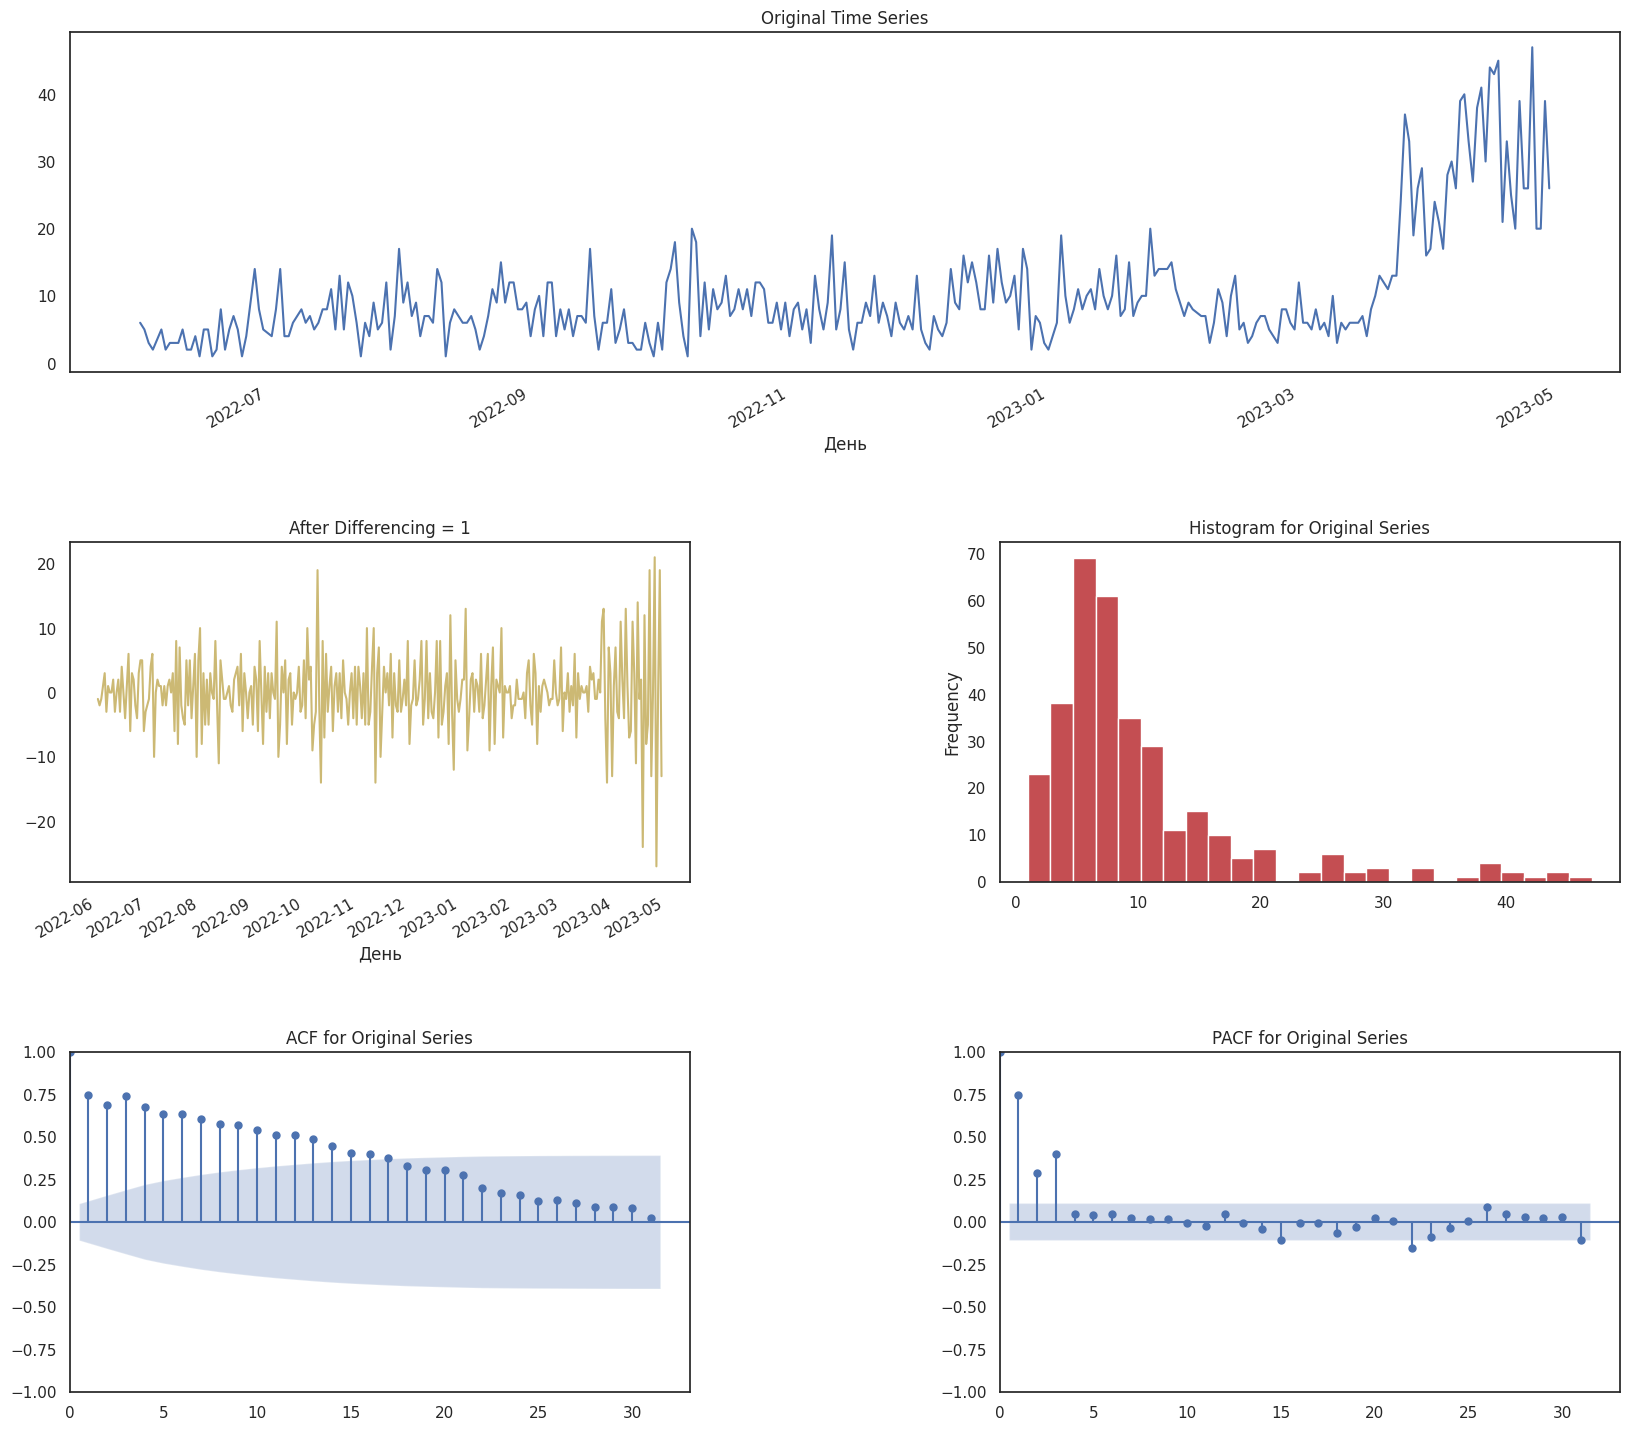

Модель показала хорошее предсказание по Фарам за валидационной выборке на месяц, с отклонением в конце месяца, на последней неделе 10%

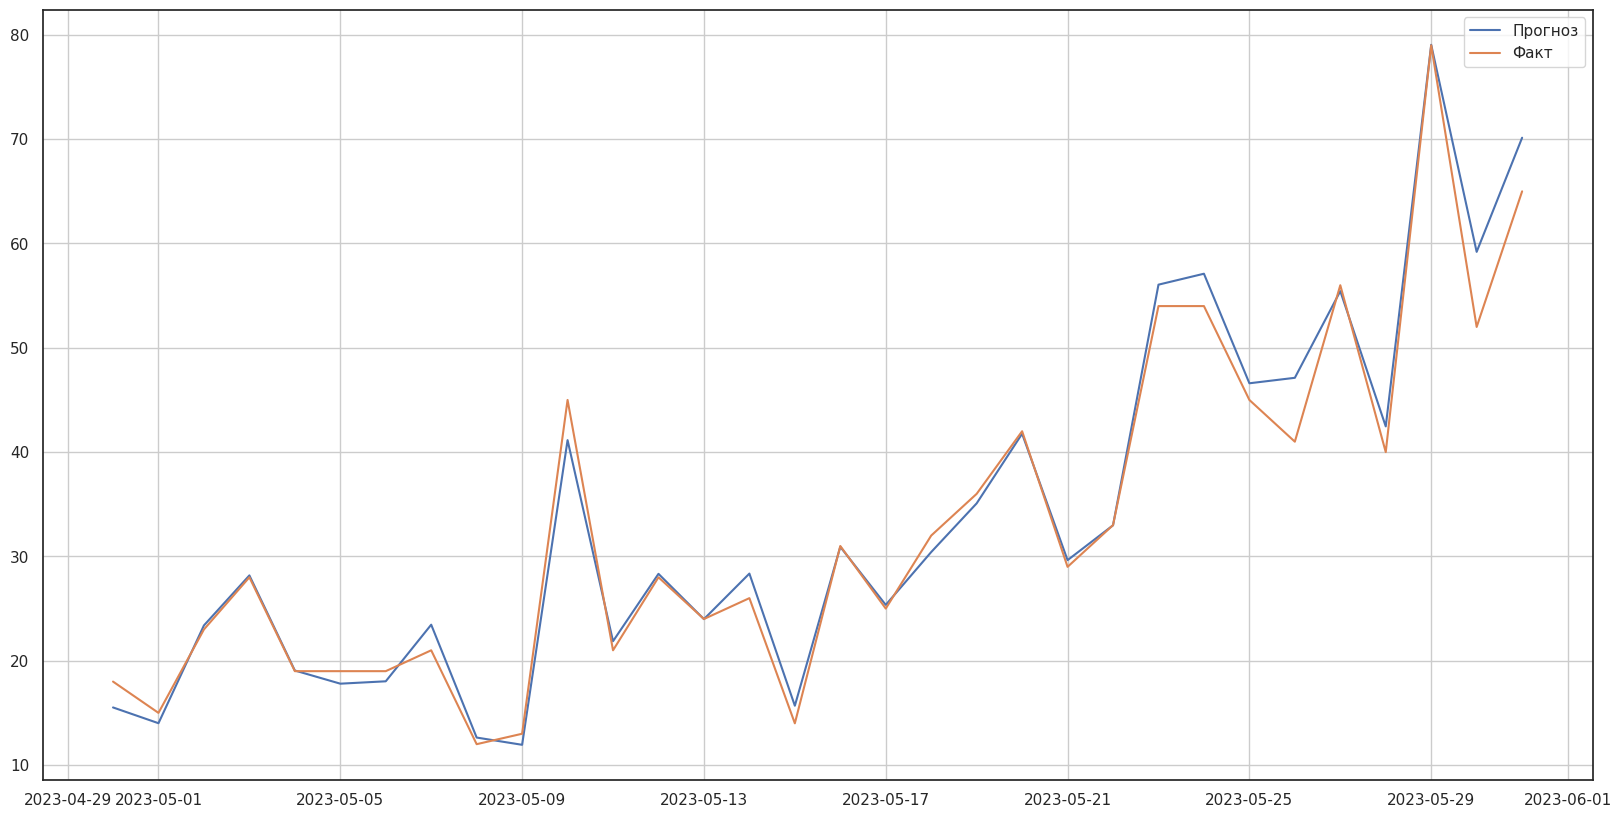

Есть куда двигаться
1. На готовой модели протестировать предсказание по конкретному товару за год имеющихся данных (хорошо продаваемого, средне, и не продаваемого)

2. Попытаться согласно ТЗ корректировать входные данные модели для получения необходимых значений Продаж. (Правильно сделать исследование влияния каждого параметра)

3. Обучить модель на полных данных всей группы Фары исключив нулевые значения

  3.1 Методом дифференциации data.diff()

  3.2 Методом дифференциации логарифмических значений np.log.diff(data) (уйти от отрицательных значений)
  
  3.3 Собственным методом

4. Для глубины предсказания необходимо увеличить базу

  1.1 Запросить более длинную выгрузку от заказчика

  1.2 Аугментация данных - Гепотеза - развернуть временной ряд, соотношения данных будет темже, выборка учеличится в 2 раза

Все перечисленные задачи помогут найти правильное направление поиска решения задачи заказчика, т.к. прогноз строится на исторических данных клиента заказчика за год. А  главное задание заказчика "Прогноз продаж любого товара" мы сможем решить только в исследованных категориях "Фары". Для решения задачи  необходима статистика общих продаж всей группы продавцов.